## Paths and Language Settings

In [1]:
evaluation_n = 'DefinitionGeneration/evaluation'


def model_name_map(lang, model_name, multilingual=None, base_path=f'{evaluation_n}/'):
    if multilingual: # model name is Llama3-ft
        seen_path = f"{base_path}LlamaDictionary-{multilingual}_ML38BI/test_seen_dbnary_{lang}.tsv"
        unseen_path = f"{base_path}LlamaDictionary-{multilingual}_ML38BI/test_unseen_dbnary_{lang}.tsv"
        
    elif model_name == 'Llama2-ft':
        seen_path = f'{base_path}LlamaDictionary-{lang}_L27BCH/test_seen_dbnary_{lang}.tsv'
        unseen_path = f'{base_path}LlamaDictionary-{lang}_L27BCH/test_unseen_dbnary_{lang}.tsv'
    elif model_name == 'Llama3-ft':
        seen_path = f'{base_path}LlamaDictionary-{lang}_ML38BI/test_seen_dbnary_{lang}.tsv'
        unseen_path = f'{base_path}LlamaDictionary-{lang}_ML38BI/test_unseen_dbnary_{lang}.tsv'
    elif model_name == 'Llama3-pt':
        seen_path = f'{base_path}/Meta-Llama-3-8B-Instruct/test_seen_dbnary_{lang}.tsv'
        unseen_path = f'{base_path}/Meta-Llama-3-8B-Instruct/test_unseen_dbnary_{lang}.tsv'

    return seen_path, unseen_path

multiilingual_models = {
    'R': 'it es fr',
    'G': 'sv de en',
    'S': 'pl ru',

    'R + G': 'it es sv de fr en',
    'R + S': 'it es pl ru fr',
    'G + S': 'pl sv ru de en',

    # 'Others': 'ja fi ru',
    'R + G + S': 'it es pl sv ru de fr en',
    'All': 'it es tr ja el fi ku pl sv ru de fr en',
}

language_families = {
    'R': ['ca', 'es', 'it', 'pt', 'fr', 'la'],
    'G': ['de', 'nl', 'da', 'sv', 'no','en'],
    'S': ['ru', 'pl'],
    'Other': ['tr', 'fi', 'ja', 'zh', 'el', 'ku', 'lt', 'mg'],
}
ordered_langs = [lang for langs in language_families.values() for lang in langs]


## Load Predictions and Detect Languages

In [2]:
import pandas as pd
from langdetect import detect
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tqdm
import os

# multilingual = False
# remove zh, lt, mg from ordered_langs
ordered_langs = [lang for lang in ordered_langs if lang != 'zh' and lang != 'lt' and lang != 'mg']

def get_confusion_data(multilingual, ordered_langs):
    # Dictionary to store true vs predicted for each model
    confusion_data = {}
    if multilingual:
        models = multiilingual_models.values()
    else:
        models = ordered_langs

    print(models)

    # Check if the files exist
    for model in models:
        languages_in_model = ordered_langs  # or however you define languages per model

        true_langs = []
        predicted_langs = []

        for lang in languages_in_model:
            _, unseen_path = model_name_map(lang, model_name=None, multilingual=model)
        
            if not os.path.exists(unseen_path):
                print(f"File not found: {unseen_path}")
                continue
            
    for model in models:
        languages_in_model = ordered_langs  # or however you define languages per model
        print(f"Processing model: {model}")

        true_langs = []
        predicted_langs = []

        for lang in tqdm.tqdm(languages_in_model):
            _, unseen_path = model_name_map(lang, model_name=None, multilingual=model)

            if model=='no' and lang == 'ku':
                # add dummy values
                continue
                
            df_unseen = pd.read_csv(unseen_path, sep='\t', engine='python', on_bad_lines='skip', encoding='ISO-8859-1')
            # print(f"language: {lang}, {len(df_unseen)}")    
            predictions = df_unseen['prediction'].tolist()

            # remove empty predictions
            predictions = [pred for pred in predictions if pred != '']
            # select 1000 
            if len(predictions) > 100:
                predictions = random.sample(predictions, 100)
            # Detect predicted language
            for pred in predictions:
                try:
                    predicted_lang = detect(pred)
                    predicted_langs.append(predicted_lang)
                except Exception as e:
                    predicted_langs.append(None)
                true_langs.append(lang)

        # Store for current model
        confusion_data[model] = pd.DataFrame({
            'true': true_langs,
            'predicted': predicted_langs
        })

    return confusion_data
    
multilingual_data = get_confusion_data(True, ordered_langs)
monolingual_data = get_confusion_data(False, ordered_langs)

dict_values(['it es fr', 'sv de en', 'pl ru', 'it es sv de fr en', 'it es pl ru fr', 'pl sv ru de en', 'it es pl sv ru de fr en', 'it es tr ja el fi ku pl sv ru de fr en'])
Processing model: it es fr


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:12<00:00,  1.57it/s]


Processing model: sv de en


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  1.91it/s]


Processing model: pl ru


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.85it/s]


Processing model: it es sv de fr en


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  2.00it/s]


Processing model: it es pl ru fr


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  1.99it/s]


Processing model: pl sv ru de en


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  2.07it/s]


Processing model: it es pl sv ru de fr en


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  1.99it/s]


Processing model: it es tr ja el fi ku pl sv ru de fr en


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  2.03it/s]


['ca', 'es', 'it', 'pt', 'fr', 'la', 'de', 'nl', 'da', 'sv', 'no', 'en', 'ru', 'pl', 'tr', 'fi', 'ja', 'el', 'ku']
File not found: /homes/rg270/DefGen/evaluation4/LlamaDictionary-no_ML38BI/test_unseen_dbnary_ku.tsv
Processing model: ca


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:15<00:00,  1.25it/s]


Processing model: es


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.73it/s]


Processing model: it


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  2.01it/s]


Processing model: pt


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.83it/s]


Processing model: fr


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:08<00:00,  2.18it/s]


Processing model: la


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.80it/s]


Processing model: de


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:06<00:00,  2.96it/s]


Processing model: nl


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.83it/s]


Processing model: da


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:11<00:00,  1.67it/s]


Processing model: sv


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:15<00:00,  1.20it/s]


Processing model: no


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  2.09it/s]


Processing model: en


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:07<00:00,  2.41it/s]


Processing model: ru


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:07<00:00,  2.38it/s]


Processing model: pl


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:04<00:00,  3.96it/s]


Processing model: tr


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.76it/s]


Processing model: fi


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:09<00:00,  2.10it/s]


Processing model: ja


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:08<00:00,  2.12it/s]


Processing model: el


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:07<00:00,  2.61it/s]


Processing model: ku


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19/19 [00:10<00:00,  1.86it/s]


In [3]:
langdetect_langs = [ # From the langdetect documentation
    "af", "ar", "bg", "bn", "ca", "cs", "cy", "da", "de", "el", "en", "es", "et", "fa", "fi",
    "fr", "gu", "he", "hi", "hr", "hu", "id", "it", "ja", "kn", "ko", "lt", "lv", "mk", "ml",
    "mr", "ne", "nl", "no", "pa", "pl", "pt", "ro", "ru", "sk", "sl", "so", "sq", "sv", "sw",
    "ta", "te", "th", "tl", "tr", "uk", "ur", "vi", "zh-cn", "zh-tw"
]


## Plot Individual Confusion Matrics

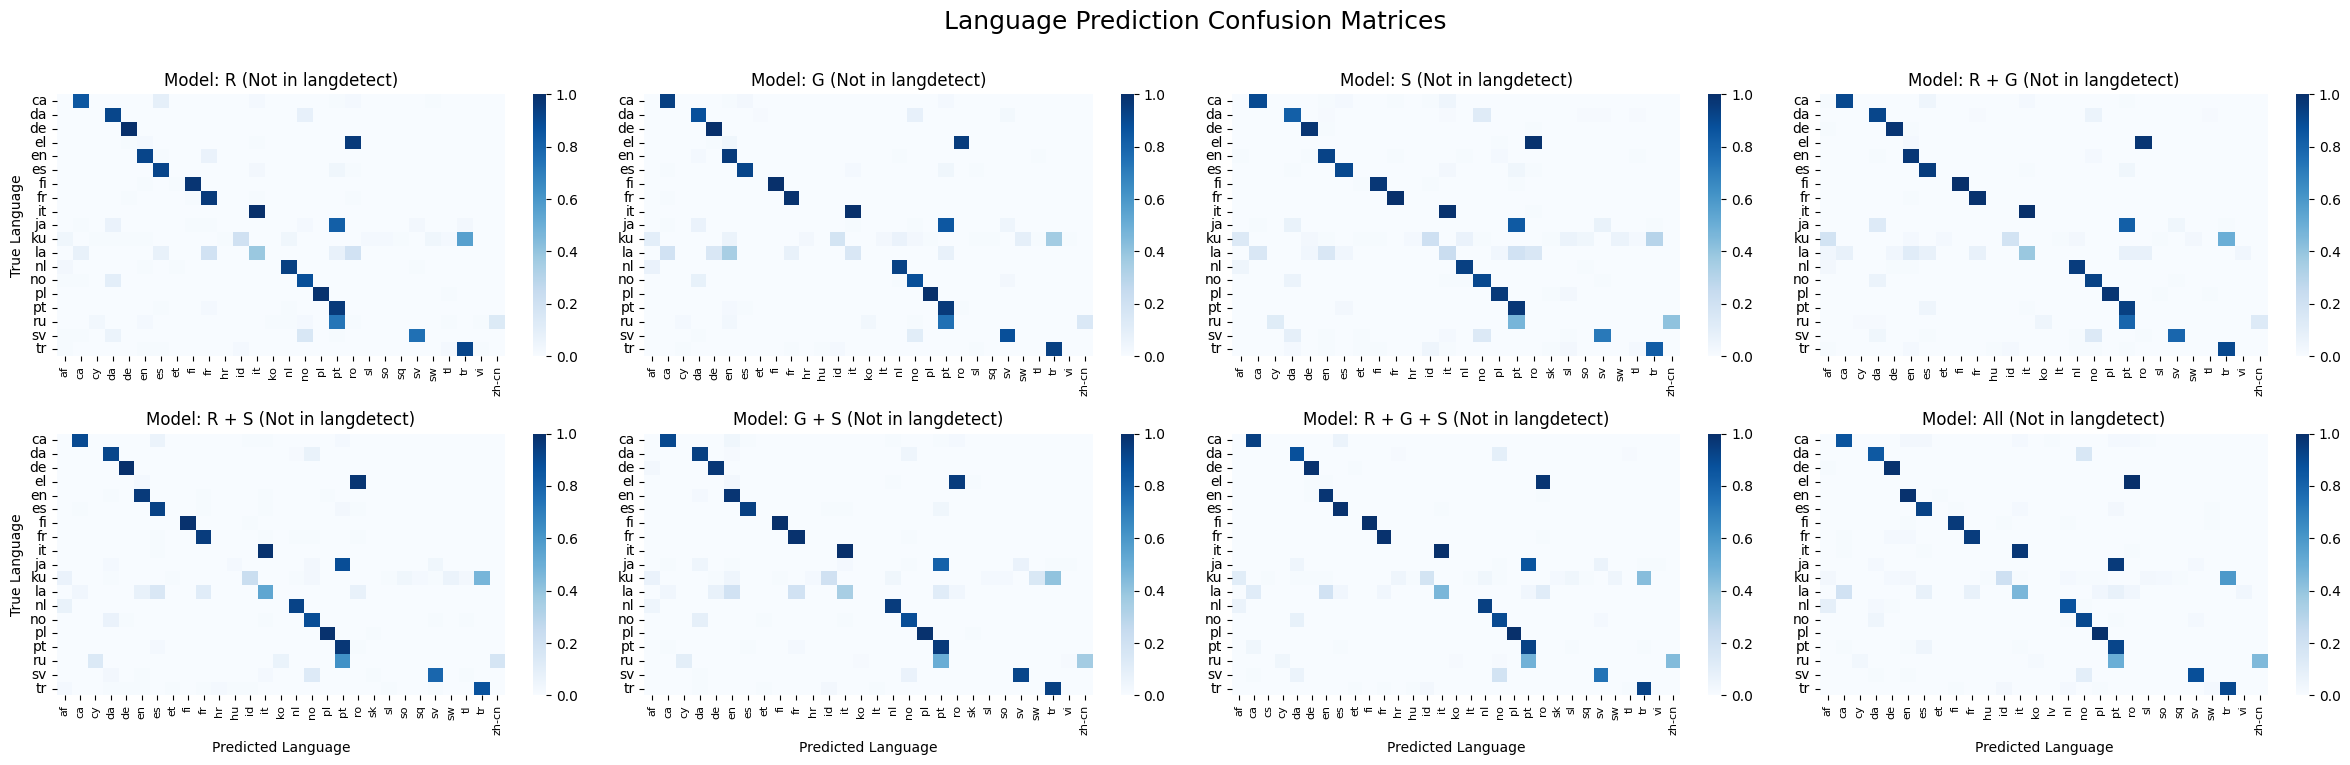

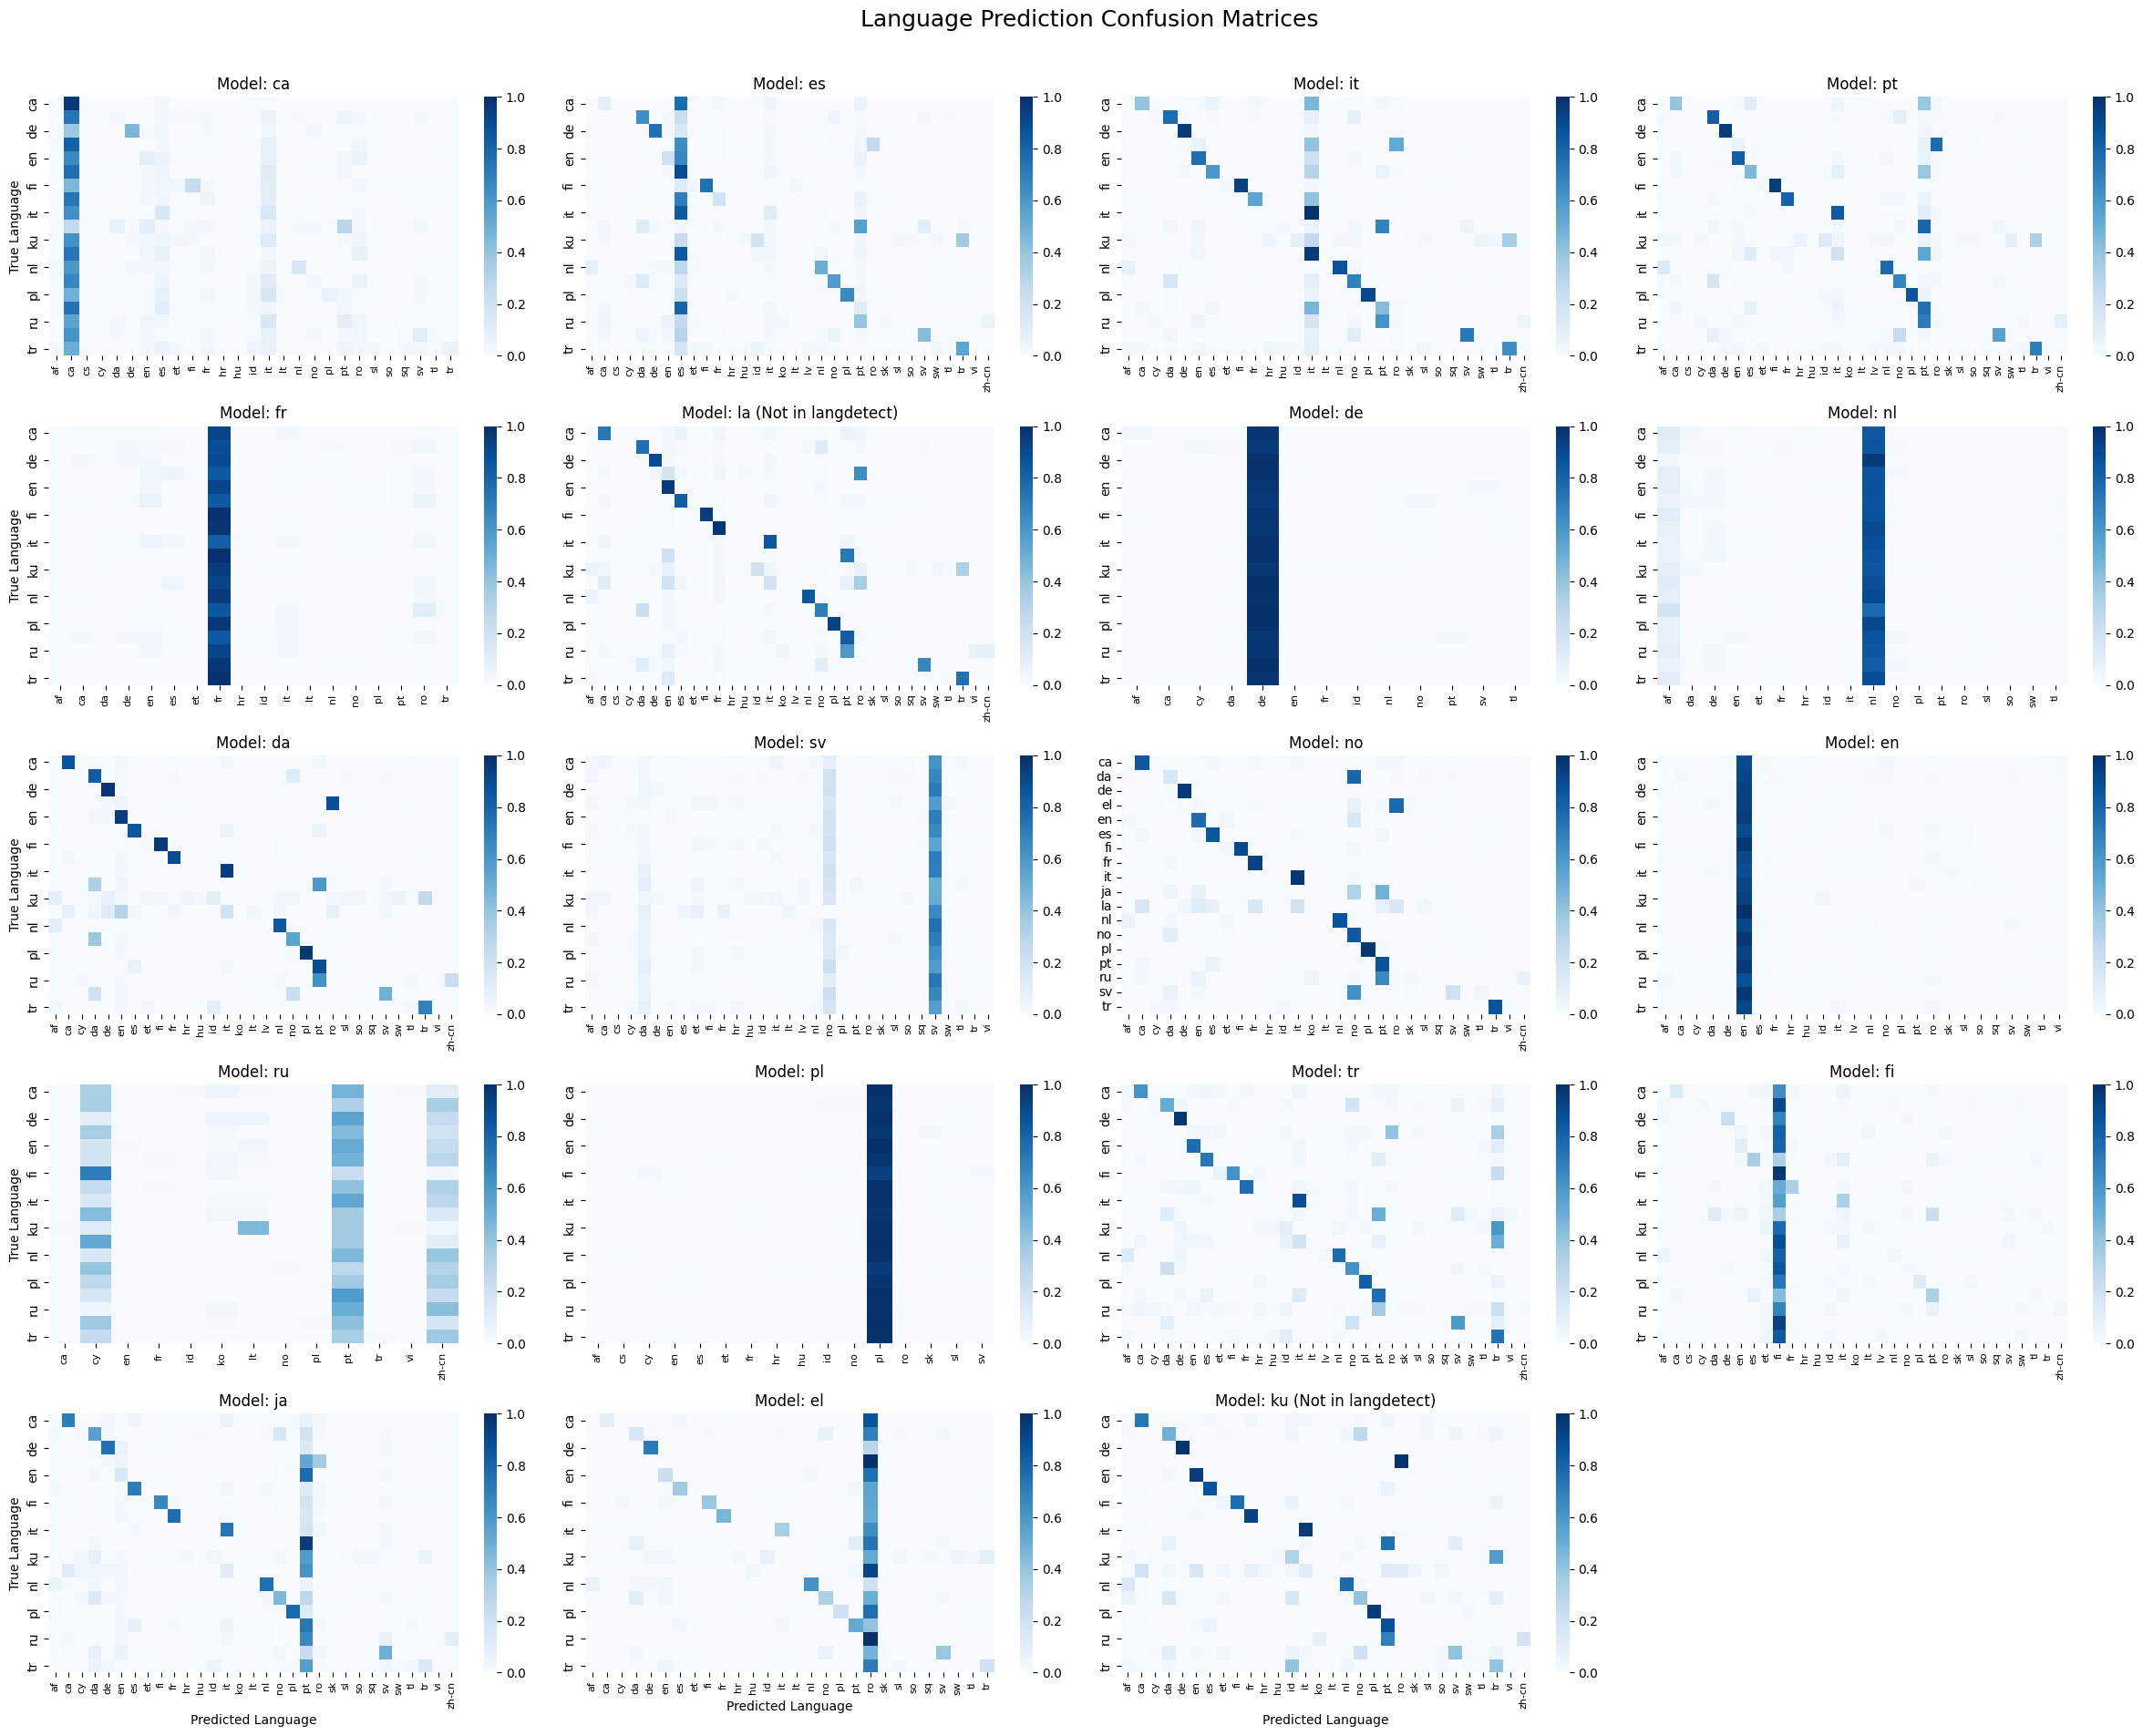

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import ceil

# Reverse the model names for labeling
multiilingual_models_reversed = {v: k for k, v in multiilingual_models.items()}

def plot_individual_models(confusion_data, multilingual):
    # Determine grid size
    n_models = len(confusion_data)
    ncols = 4  # You can change this if you'd prefer wider plots
    nrows = ceil(n_models / ncols)

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, (model, df) in enumerate(confusion_data.items()):
        ax = axes[i]
        cm = pd.crosstab(df['true'], df['predicted'], rownames=['True'], colnames=['Predicted'], normalize='index')
        sns.heatmap(cm, annot=False, fmt=".2f", cmap='Blues', cbar=True, ax=ax, vmin=0, vmax=1)

        if multilingual:
            model_label = multiilingual_models_reversed.get(model, model)  # fallback to original if not in reversed
        else:
            model_label = model
        if model_label not in langdetect_langs:
            model_label += ' (Not in langdetect)'
        ax.set_title(f'Model: {model_label}', fontsize=12)

        # Show xlabels only on bottom row
        if i // ncols == nrows - 1:
            ax.set_xlabel('Predicted Language')
        else:
            ax.set_xlabel('')

        # Show ylabels only on left column
        if i % ncols == 0:
            ax.set_ylabel('True Language')
        else:
            ax.set_ylabel('')

        # ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
        ax.set_xticks(np.arange(len(cm.columns)) + 0.5)
        ax.set_xticklabels(cm.columns, rotation=90, ha='center')
        ax.tick_params(axis='x', labelsize=8)

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set the main title
    fig.suptitle('Language Prediction Confusion Matrices', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

plot_individual_models(multilingual_data, multilingual=True)
plot_individual_models(monolingual_data, multilingual=False)


## Combine Confusion Matrices

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# def make_combined_cm(confusion_data, multilingual=False):
#     # Initialize combined confusion matrix to full size (55x55)
#     combined_cm = pd.DataFrame(0, index=langdetect_langs, columns=langdetect_langs)

#     for model, df in confusion_data.items():
#         if not multilingual:
#             filtered_df = df[df['true'].isin(langdetect_langs) & df['predicted'].isin(langdetect_langs)]
#         else:
#             filtered_df = df
#         cm = pd.crosstab(filtered_df['true'], filtered_df['predicted'])
        
#         cm = cm.reindex(index=langdetect_langs, columns=langdetect_langs, fill_value=0)
        
#         combined_cm = pd.DataFrame(
#             np.maximum(combined_cm.values, cm.values),
#             index=langdetect_langs,
#             columns=langdetect_langs
#         )


#     # Normalize by row to get proportions
#     combined_cm_normalized = combined_cm.div(combined_cm.sum(axis=1), axis=0).fillna(0)

#     # make column names and index uppercase
#     combined_cm_normalized.columns = combined_cm_normalized.columns.str.upper()
#     combined_cm_normalized.index = combined_cm_normalized.index.str.upper()

#     # only keep the 17 languages in the confusion_data results
#     # Get the actual set of languages that appear in confusion_data
#     langs_present = set()
#     for df in confusion_data.values():
#         langs_present.update(df['true'].unique())

#     # Keep only those languages that are also in langdetect_langs
#     keep = sorted(set(langdetect_langs).intersection(langs_present))
#     keep = [lang.upper() for lang in keep]  # üîÅ match case with matrix labels

#     combined_cm_normalized = combined_cm_normalized[keep].loc[keep]

#     return combined_cm_normalized
import numpy as np  # <- make sure this is imported

def make_combined_cm(confusion_data, multilingual=False):
    # Initialize combined confusion matrix to full size (55x55)
    combined_cm = pd.DataFrame(0, index=langdetect_langs, columns=langdetect_langs)

    for model, df in confusion_data.items():
        if not multilingual:
            filtered_df = df[df['true'].isin(langdetect_langs) & df['predicted'].isin(langdetect_langs)]
        else:
            filtered_df = df

        cm = pd.crosstab(filtered_df['true'], filtered_df['predicted'])
        cm = cm.reindex(index=langdetect_langs, columns=langdetect_langs, fill_value=0)

        # Correct: take element-wise max *in place*
        combined_cm = combined_cm.combine(cm, func=np.maximum)

    # Make column names and index uppercase
    combined_cm.columns = combined_cm.columns.str.upper()
    combined_cm.index = combined_cm.index.str.upper()

    # Filter to relevant languages
    langs_present = set()
    for df in confusion_data.values():
        langs_present.update(df['true'].unique())

    keep = sorted(set(langdetect_langs).intersection(langs_present))
    keep = [lang.upper() for lang in keep]

    combined_cm = combined_cm[keep].loc[keep]

    return combined_cm

monolingual_combined_cm = make_combined_cm(monolingual_data, multilingual=False)
multilingual_combined_cm = make_combined_cm(multilingual_data, multilingual=True)

## Plot the Heatmaps

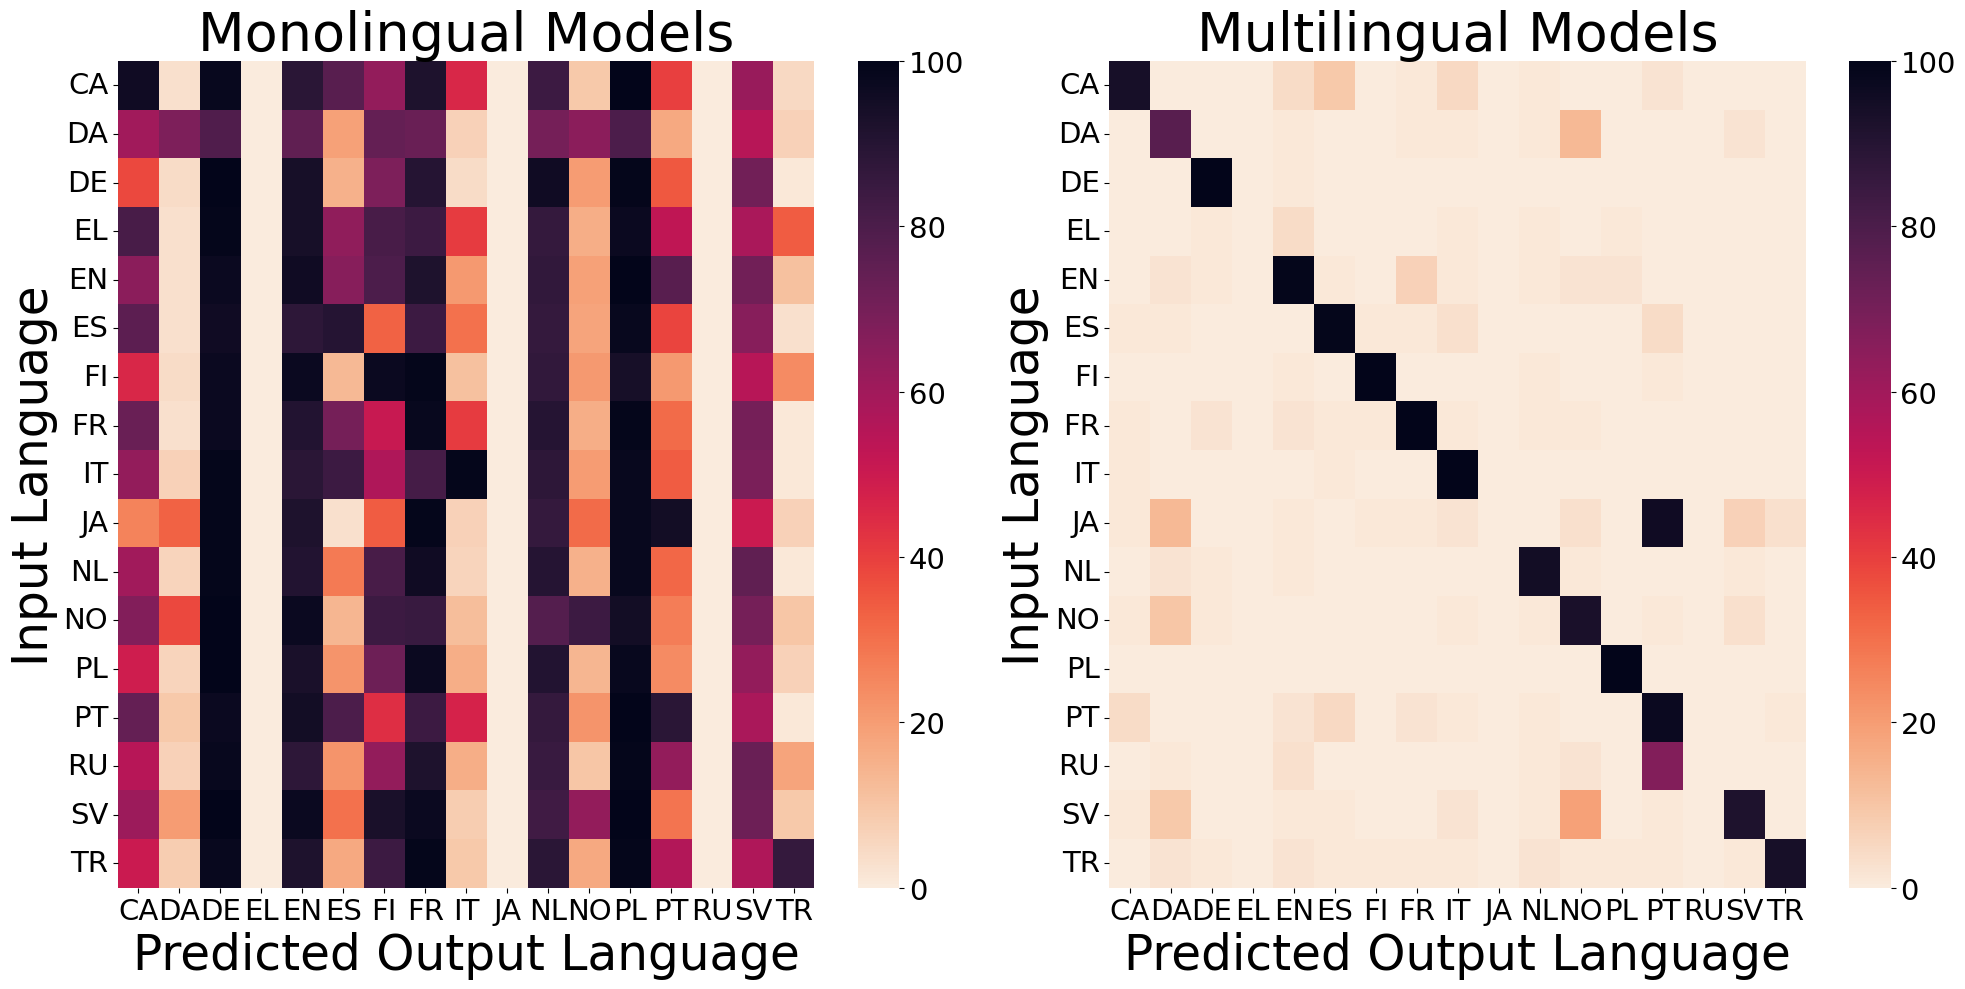

In [19]:
# Create a figure with monolingual and multilingual data side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
font_size = 35  # Adjust as needed
smaller_font_size = font_size - 14

# Determine global color scale limits
vmin = min(monolingual_combined_cm.values.min(), multilingual_combined_cm.values.min())
vmax = max(monolingual_combined_cm.values.max(), multilingual_combined_cm.values.max())

# Plot monolingual heatmap
mono_hm = sns.heatmap(
    monolingual_combined_cm, annot=False, fmt=".2f", cmap='rocket_r',
    cbar=True, ax=axes[0], vmin=vmin, vmax=vmax
)
axes[0].set_title('Monolingual Models', fontsize=font_size + 4)
axes[0].set_xlabel('Predicted Output Language', fontsize=font_size)
axes[0].set_ylabel('Input Language', fontsize=font_size)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, ha='center', fontsize=smaller_font_size)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=smaller_font_size)
mono_hm.collections[0].colorbar.ax.tick_params(labelsize=smaller_font_size)

# Plot multilingual heatmap
multi_hm = sns.heatmap(
    multilingual_combined_cm, annot=False, fmt=".2f", cmap='rocket_r',
    cbar=True, ax=axes[1], vmin=vmin, vmax=vmax
)
axes[1].set_title('Multilingual Models', fontsize=font_size + 4)
axes[1].set_xlabel('Predicted Output Language', fontsize=font_size)
axes[1].set_ylabel('Input Language', fontsize=font_size)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, ha='center', fontsize=smaller_font_size)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=smaller_font_size)
multi_hm.collections[0].colorbar.ax.tick_params(labelsize=smaller_font_size)

plt.tight_layout()
plt.show()


## Evaluating the Accuracy of Langdetect
### Looking at the 'example' column

In [7]:
# Evaluate performance of the langdetect library

import os
import pandas as pd
from langdetect import detect
import random

target = 'example'

path_start = '/homes/rg270/DefGen/evaluation4/Meta-Llama-3-8B-Instruct'
files = os.listdir(path_start)
files = [f for f in files if 'unseen' in f]

true_langs = []
predicted_langs = []
for file in files:
    df_unseen = pd.read_csv(path_start+ '/' + file, sep='\t', engine='python', on_bad_lines='skip', encoding='ISO-8859-1')
    lang = file.replace('test_unseen_dbnary_','').replace('.tsv','')

    predictions = df_unseen[target].tolist()

    # remove empty predictions
    predictions = [pred for pred in predictions if pred != '']
    # select 1000 
    if len(predictions) > 1000:
        predictions = random.sample(predictions, 1000)
    # Detect predicted language
    for pred in predictions:
        try:
            predicted_lang = detect(pred)
            predicted_langs.append(predicted_lang)
        except Exception as e:
            predicted_langs.append(None)
        true_langs.append(lang)

# Store for current model
confusion_data = pd.DataFrame({
    'true': true_langs,
    'predicted': predicted_langs
})

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
# Drop rows where true or predicted is None
clean_data = confusion_data.dropna(subset=['true', 'predicted'])


f1 = f1_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
precision = precision_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
recall = recall_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
accuracy = accuracy_score(clean_data['true'], clean_data['predicted'])

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")



F1 Score: 0.57
Precision: 0.55
Recall: 0.61
Accuracy: 0.61


In [9]:
clean_data = clean_data[~clean_data['true'].isin(['ku','la'])]
print("Remaining number of languages:", len(clean_data['true'].unique()))

f1 = f1_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
precision = precision_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
recall = recall_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
accuracy = accuracy_score(clean_data['true'], clean_data['predicted'])

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Remaining number of languages: 20
F1 Score: 0.62
Precision: 0.61
Recall: 0.65
Accuracy: 0.65


### The accuracy isn't great, but that's because of a few low-resource outlier languages
### When these are excluded, the accuracy is good:

In [10]:
clean_data = clean_data[~clean_data['true'].isin(['ja', 'el', 'ru','ku','la','mg','zh'])]
print("Remaining number of languages:", len(clean_data['true'].unique()))

f1 = f1_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
precision = precision_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
recall = recall_score(clean_data['true'], clean_data['predicted'], average='weighted', zero_division=0)
accuracy = accuracy_score(clean_data['true'], clean_data['predicted'])

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Remaining number of languages: 15
F1 Score: 0.90
Precision: 0.93
Recall: 0.89
Accuracy: 0.89
